In [1]:
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim

import sys
spath = '../scripts'
sys.path.insert(0, spath)

import kaldi_utils
from models import *
from notebook import *

### Loading data from drive

In [2]:
data_folder = '/export/b03/carlosc/data/2020/augmented'
embedding_dim = 128

dev_rttm     = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/ref.rttm'
dev_segments = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/segments'
dev_ivectors = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_ivectors/ivector.txt'
dev_xvectors = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_xvectors/xvector.txt'
dev_files_segments = get_rttm_segments_features(dev_rttm, dev_segments, dev_ivectors, dev_xvectors)

eval_rttm     = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/ref.rttm'
eval_segments = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/segments'
eval_ivectors = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_ivectors/ivector.txt'
eval_xvectors = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_xvectors/xvector.txt'
eval_files_segments = get_rttm_segments_features(eval_rttm, eval_segments, eval_ivectors, eval_xvectors)

### Filtering data

In [3]:
dev_files_segments_lim = limit_segments_speakers_length(dev_files_segments, 1, log = True)
eval_files_segments_lim = limit_segments_speakers_length(eval_files_segments, 1, log = True)

Kept 39533 of 70546: 0.5603861310350693
Kept 38688 of 66651: 0.5804564072557051


In [4]:
def invert_speaker_weights(speakers_weights):
    weight_sum = sum(speakers_weights.values())
    weight_count = len(speakers_weights.values())
    speakers_weights_inverse = {}
    for speaker_name, weight in speakers_weights.items():
        speakers_weights_inverse[speaker_name] = (weight_sum - speakers_weights[speaker_name]) / ((weight_count - 1) * weight_sum)
    return speakers_weights_inverse

class Files_dataset(Dataset):
    def __init__(self,
                 embedding_dim,
                 files_segments,
                 files_speakers = {},
                 models_generation_lengths = [3],
                 models_container_length = 2,
                 include_zeros = True,
                 include_overlaps = False,
                 feature = 'ivectors',
                 zeros_multiplier = 1.0):
        self.embedding_dim = embedding_dim
        self.files_segments = files_segments
        self.files_speakers = {}
        for file_id in self.files_segments:
            self.files_speakers[file_id] = files_speakers[file_id] if file_id in files_speakers \
            else get_first_speakers(self.files_segments[file_id])
        self.models_generation_lengths = models_generation_lengths
        self.models_container_length = models_container_length
        self.include_zeros = include_zeros
        self.include_overlaps = include_overlaps
        self.feature = feature
        self.zeros_multiplier = zeros_multiplier
        
        
        self.speakers_segments_indexes = {}
        self.speakers_models = {}
        self.speakers_models_combinations_length = {}
        self.files_turns = {}
        files_turns_count = {}
        self.files_lengths = {}
        self.files_speakers_permutations = {}
        self.files_speakers_weights = {}
        self.lookup = []
        self.length = 0
        for file_id, segments in self.files_segments.items():
            self.speakers_segments_indexes[file_id] = get_speakers_segments_indexes(enumerate(segments))
            self.speakers_models[file_id] = get_speakers_models(segments,
                                                                self.speakers_segments_indexes[file_id],
                                                                self.models_generation_lengths,
                                                                self.files_speakers[file_id])
            self.speakers_models_combinations_length[file_id] = len(self.models_generation_lengths) ** len(self.speakers_models[file_id].keys())
            self.files_turns[file_id] = 8
            files_turns_count[file_id] = 0
            self.files_lengths[file_id] = self.files_turns[file_id] * self.speakers_models_combinations_length[file_id] * len(segments)
            self.files_speakers_permutations[file_id] = Permutations(self.speakers_models[file_id].keys(),
                                                                     self.files_lengths[file_id],
                                                                     self.models_container_length,
                                                                     self.include_zeros)
            speakers_weights = self.files_speakers_permutations[file_id].get_speakers_names_counts()
            if self.include_zeros and '0' in speakers_weights:
                speakers_weights['0'] *= (1 / self.zeros_multiplier)
            self.files_speakers_weights[file_id] = invert_speaker_weights(speakers_weights)
            self.lookup.append([file_id for _ in range(self.files_turns[file_id] * self.speakers_models_combinations_length[file_id])])
            
        self.lookup = list(itertools.chain(*self.lookup))
        random.shuffle(self.lookup)
        for index, file_id in enumerate(self.lookup):
            segments = self.files_segments[file_id]
            self.lookup[index] = { 'onset': self.length, 'end': self.length + len(segments) - 1,
                                  'file_id': file_id, 'turn': files_turns_count[file_id] }
            files_turns_count[file_id] += 1
            self.length += len(segments)

    def __len__(self):
        return self.length

    def __getitem__(self, key):
        lookup = [value for value in self.lookup if value['onset'] <= key and key <= value['end']][0]
        file_id = lookup['file_id']
        turn = lookup['turn']
        segment_index = key - lookup['onset']

        segments = self.files_segments[file_id]
        file_index = turn * len(segments) + segment_index
        
        _, model_index = divmod(file_index, self.speakers_models_combinations_length[file_id] * len(segments))
        model_index, _ = divmod(model_index, len(segments))
        
        models = {}
        models_speakers_names = list(self.speakers_models[file_id].keys())
        remainder = model_index
        for speaker_name_index, speaker_name in enumerate(models_speakers_names):
            models_lengths = [len(self.speakers_models[file_id][speaker_name].keys()) for speaker_name in models_speakers_names[speaker_name_index + 1:]]
            if speaker_name_index != len(models_speakers_names) - 1:
                model_index, remainder = divmod(remainder, int(np.prod(models_lengths)))
            else:
                model_index = remainder
            models[speaker_name] = self.speakers_models[file_id][speaker_name][list(self.speakers_models[file_id][speaker_name].keys())[model_index]]

        permutation = self.files_speakers_permutations[file_id][file_index]
        models_container = [models[speaker_name] if speaker_name != '0' else { 'ivectors': [Ivector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))], 'xvectors': [Ivector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))] } for speaker_name in permutation]
        
        segment = segments[segment_index]
        segment_speakers_names = [speaker.get_name() for speaker in segment.get_speakers()]
        
        x = [embeddings[self.feature][0].get_value() for embeddings in models_container + [{ 'ivectors': segment.get_ivectors(), 'xvectors': segment.get_xvectors() }]]
        y = np.asarray([speaker_name in segment_speakers_names for speaker_name in permutation], dtype = np.float32)
        w =  np.asarray([self.files_speakers_weights[file_id][speaker_name] for speaker_name in permutation], dtype = np.float32)
        return x, y, w

In [5]:
class Model(nn.Module):
    def __init__(self, b, M):
        super(Model, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d((M + 1), M ** 3, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 3, M ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 2, M, 3),
            nn.ReLU(),
        )
        self.lstm1 = nn.Sequential(
            nn.LSTM(b - 6, 8, bidirectional = True),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(M * 2 * 8, M * 4),
            nn.ReLU(),
            nn.Linear(M * 4, M * 2),
            nn.ReLU(),
            nn.Linear(M * 2, M),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = torch.stack(x, 1)
        x = self.cnn1(x)
        x, _ = self.lstm1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

class Train_graph:
    def __init__(self, training_loss, validation_loss = None):
        self.step = 0
        self.training_losses_x = [self.step - 1, self.step]
        self.training_losses_y = [training_loss, training_loss]
        self.validation_losses_x = None if validation_loss is None else [self.step - 1, self.step]
        self.validation_losses_y = None if validation_loss is None else [validation_loss, validation_loss]
        
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        
        self.training_line, = self.ax.plot(self.training_losses_x, self.training_losses_y, '--', label = 'Training')
        self.validation_line = None if validation_loss is None else self.ax.plot(self.validation_losses_x, self.validation_losses_y, label = 'Validation')[0]
            
        self.ax.set_ylim(0, training_loss if validation_loss is None else (training_loss if training_loss > validation_loss else validation_loss))
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    def draw(self, training_loss, validation_loss = None):
        self.step += 1
        self.training_losses_x.append(self.step)
        self.training_losses_y.append(training_loss)
        self.training_line.set_xdata(self.training_losses_x)
        self.training_line.set_ydata(self.training_losses_y)
        
        if validation_loss is not None:
            if self.validation_line is None:
                self.validation_losses_x = [self.step - 1]
                self.validation_losses_y = [validation_loss]
                self.validation_line = self.ax.plot(self.validation_losses_x, self.validation_losses_y, label = 'Validation')[0]
                self.ax.legend()
            self.validation_losses_x.append(self.step)
            self.validation_losses_y.append(validation_loss)
            self.validation_line.set_xdata(self.validation_losses_x)
            self.validation_line.set_ydata(self.validation_losses_y)
        self.ax.set_xlim(0, self.step + 1)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-klcf5y1f because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<IPython.core.display.Javascript object>


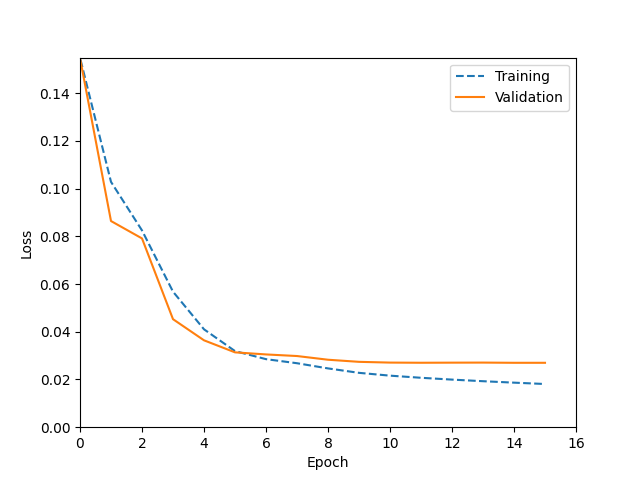

In [7]:
seed = 19970917 #25005233 19970917
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

models_container_length = 6

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

dev_files_ids = list(dev_files_segments_lim.keys())
dev_validation_files_ids = random.sample(dev_files_ids, int(len(dev_files_ids) * 0.3))
dev_train_files_ids = [file_id for file_id in dev_files_ids if file_id not in dev_validation_files_ids]

dev_train_files_segments = {}
for file_id in dev_train_files_ids:
    dev_train_files_segments[file_id] = dev_files_segments_lim[file_id]
dev_validation_files_segments = {}
for file_id in dev_validation_files_ids:
    dev_validation_files_segments[file_id] = dev_files_segments_lim[file_id]

dev_train_dataset = Files_dataset(embedding_dim,
                                  dev_train_files_segments,
                                  models_generation_lengths = [5],
                                  models_container_length = models_container_length, feature = 'ivectors')
dev_validation_dataset = Files_dataset(embedding_dim,
                                       dev_validation_files_segments,
                                       models_generation_lengths = [5],
                                       models_container_length = models_container_length, feature = 'ivectors')

dev_train_dataloader = DataLoader(dev_train_dataset, batch_size = 32, num_workers = 8)
dev_validation_dataloader = DataLoader(dev_validation_dataset, batch_size = 32, num_workers = 8)

net = Model(embedding_dim, models_container_length).to(device, non_blocking = True)
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

losses = []
with torch.no_grad():
    for dataloader in [dev_train_dataloader]:
        for x, y, w in dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()
            criterion = nn.BCELoss(w)
            y_ = net(x)
            loss = criterion(y_, y)
            losses.append(loss.data)
train_loss = (np.sum(losses) / len(losses)).cpu()

validation_losses = []
with torch.no_grad():
    for dataloader in [dev_validation_dataloader]:
        for x, y, w in dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()
            criterion = nn.BCELoss(w)
            y_ = net(x)
            loss = criterion(y_, y)
            validation_losses.append(loss.data)
validation_loss = (np.sum(validation_losses) / len(validation_losses)).cpu()


train_graph = Train_graph(train_loss, validation_loss)

for train_dataloader, validation_dataloader in [(dev_train_dataloader, dev_validation_dataloader)]:
    for epoch in range(15):
        losses = []
        for x, y, w in train_dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()

            criterion = nn.BCELoss(w)
            net.zero_grad()
            y_ = net(x)
            loss = criterion(y_, y)
            loss.backward()
            optimizer.step()

            losses.append(loss.data)
        train_loss = np.sum(losses) / len(losses)
        
        validation_losses = []
        with torch.no_grad():
            for x, y, w in validation_dataloader:
                x = [tensor.to(device, non_blocking = True).float() for tensor in x]
                y = y.to(device, non_blocking = True).float()
                w = w.to(device, non_blocking = True).float()
                criterion = nn.BCELoss(w)
                y_ = net(x)
                loss = criterion(y_, y)
                
                validation_losses.append(loss)
        validation_loss = np.sum(validation_losses) / len(validation_losses)
        
        train_graph.draw(train_loss, validation_loss)
        print(train_loss, validation_loss, end = '\r')

In [8]:
class File_dataset(Dataset):
    def __init__(self,
                 embedding_dim,
                 segments,
                 speakers = [],
                 models_generation_length = 5,
                 models_container_length = 2,
                 feature = 'ivectors'):
        self.embedding_dim = embedding_dim
        self.segments = segments
        self.speakers = speakers[:models_container_length]
        if len(self.speakers) < models_container_length:
            speakers = [speaker for speaker in get_first_speakers(segments) if speaker not in self.speakers]
            self.speakers += speakers[:models_container_length - len(self.speakers)]
            self.speakers += ['0' for i in range(models_container_length - len(self.speakers))]                
        self.models_generation_length = models_generation_length
        self.models_container_length = models_container_length
        self.feature = feature
        self.length = len(segments)
        
        self.speakers_segments_indexes = get_speakers_segments_indexes(enumerate(segments))
        self.speakers_models = get_speakers_models(segments,
                                                   self.speakers_segments_indexes,
                                                   [self.models_generation_length],
                                                   self.speakers)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, key):
        segment = self.segments[key]
        models_container = [self.speakers_models[speaker][self.models_generation_length] if speaker != '0' else { 'ivectors': [Ivector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))], 'xvectors': [Xvector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))] } for speaker in self.speakers]
        x = [embeddings[self.feature][0].get_value() for embeddings in models_container + [{ 'ivectors': segment.get_ivectors(), 'xvectors': segment.get_xvectors() }]]
        return x, key
    
def net_scoring(x, net, device):
    with torch.no_grad():
        x = [tensor.to(device) for tensor in x]
        y_ = net(x)
        return y_.cpu().numpy()[0]
    
def get_custom_rttm(segment, speaker_name):
    return segment.get_type() + ' ' + \
        segment.get_file_id() + ' ' + \
        segment.get_speakers()[0].get_channel_id() + ' ' + \
        str(round(segment.get_turn_onset(), 3)) + ' ' + \
        str(round(segment.get_turn_duration(), 3)) + ' ' + \
        segment.get_orthography_field() + ' ' + \
        segment.get_speakers()[0].get_type() + ' ' + \
        speaker_name + ' ' + \
        segment.get_confidence_score() + ' ' + \
        segment.get_signal_lookahead_time() + '\n'

eval_files_speakers = get_first_speakers(eval_files_segments, models_container_length)

groundtruth_rttm = ''
result_rttm = ''
post_rttm = ''
for file_id, segments in eval_files_segments_lim.items():
    groundtruth_segments = []
    result_segments = []
    file_dataset = File_dataset(embedding_dim,
                                segments,
                                models_container_length = models_container_length,
                                feature = 'ivectors')
    file_dataloader = DataLoader(file_dataset)
    for x, segment_index in file_dataloader:
        segment = segments[segment_index]
        if len(groundtruth_segments) > 0 \
        and groundtruth_segments[-1].has_overlap(segment) \
        and groundtruth_segments[-1].has_same_speakers(segment):
            groundtruth_segments[-1].set_turn_end(segment.get_turn_end())
        else:
            groundtruth_segments.append(segment)

        y_ = net_scoring(x, net, device)
        index = np.argmax(y_)
        result_segment = Segment(segment)
        result_speaker = result_segment.get_speakers()[0]
        result_speaker.set_name(str(index))
        result_segment.set_speakers([result_speaker])
        if len(result_segments) > 0 \
        and result_segments[-1].has_overlap(result_segment) \
        and result_segments[-1].has_same_speakers(result_segment):
            result_segments[-1].set_turn_end(result_segment.get_turn_end())
        else:
            result_segments.append(result_segment)

    post_segments = [Segment(result_segments[0])]
    for index, t_segment in enumerate(result_segments):
        if index > 1:
            t_1_segment = result_segments[index - 1]
            t_2_segment = post_segments[-1]
            if t_segment.has_overlap(t_2_segment) and t_segment.has_overlap(t_1_segment) \
            and t_segment.has_same_speakers(t_2_segment):
                post_segments[-1].set_turn_end(t_1_segment.get_turn_end())
            else:
                post_segments.append(Segment(t_1_segment))
    if post_segments[-1].has_overlap(result_segments[-1]) \
    and post_segments[-1].has_same_speakers(result_segments[-1]):
        post_segments[-1].set_turn_end(result_segments[-1].get_turn_end())
    else:
        post_segments.append(Segment(result_segments[-1]))            
        
    groundtruth_rttm += ''.join([segment.get_rttm() for segment in groundtruth_segments])
    result_rttm += ''.join([segment.get_rttm() for segment in result_segments])
    post_rttm += ''.join([segment.get_rttm() for segment in post_segments])
    
        
tmp_folder = 'batch/20200831'
!mkdir -p $tmp_folder

file = open(tmp_folder + '/groundtruth.rttm', 'w')
file.write(groundtruth_rttm)
file.close()
        
file = open(tmp_folder + '/result.rttm', 'w')
file.write(result_rttm)
file.close()

file = open(tmp_folder + '/post.rttm', 'w')
file.write(post_rttm)
file.close()
    
kaldi_utils.md_eval(tmp_folder + '/groundtruth.rttm', tmp_folder + '/result.rttm', tmp_folder)
!cat $tmp_folder/der.log

kaldi_utils.md_eval(tmp_folder + '/groundtruth.rttm', tmp_folder + '/post.rttm', tmp_folder)
!cat $tmp_folder/der.log
    

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown data type.
Xvector: unknown dat

command line (run on 2020 Sep 24 at 22:22:44) Version: 22  ../../../../tools/sctk-2.4.10/src/md-eval/md-eval.pl -r batch/20200831/groundtruth.rttm -s batch/20200831/post.rttm

Time-based metadata alignment

Metadata evaluation parameters:
    time-optimized metadata mapping
        max gap between matching metadata events = 1 sec
        max extent to match for SU's = 0.5 sec

Speaker Diarization evaluation parameters:
    The max time to extend no-score zones for NON-LEX exclusions is 0.5 sec
    The no-score collar at SPEAKER boundaries is 0 sec

Exclusion zones for evaluation and scoring are:
                             -----MetaData-----        -----SpkrData-----
     exclusion set name:     DEFAULT    DEFAULT        DEFAULT    DEFAULT
     token type/subtype      no-eval   no-score        no-eval   no-score
             (UEM)              X                         X
         LEXEME/un-lex                    X                          
        NON-LEX/breath                       